# NLP Hackathon - 18PD26

## Package import handling

In [84]:
import pandas as pd
import numpy as np
import glob
import shutil

## Preprocessing and data file importing


#### Download data file into workspace

In [85]:
# using wget to download datafile into workspace

#!pip install wget

import wget
url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/7zbk8zsd8y-1.zip"
filename = wget.download(url)

# unzipping downloaded datafile

import zipfile
with zipfile.ZipFile("/content/"+filename, 'r') as zip_ref:
    zip_ref.extractall("/content/data_files")


#### Combining all data files into one single file

In [86]:
# combining all individual data files into a single txt file

combineFile = 'data.txt'

with open(combineFile,'wb') as wf:
    for filename in glob.glob('/content/data_files/*.txt'):
        if filename == combineFile:
            continue
        with open(filename,'rb') as rf:
            shutil.copyfileobj(rf,wf)

In [87]:
# reading data from file

with open('/content/data.txt',encoding = 'unicode_escape') as file:
    data = file.read()

#### Preprocessing text data

In [88]:
import regex as re 
import string

In [89]:
# removing empty newlines
regex = r"(\n)\n+"
subst = "\\n"

data = re.sub(regex, subst, data, 0, re.MULTILINE)

## Solutions

### 1. Automatic generation user stories for different stakeholders /roles


#### Preprocessing

In [90]:
#Regexing all user roles and stories
regex = r"As\s[a-z]+\s([^,]+),\s(.*)[\n]"

matches = re.finditer(regex, data, re.MULTILINE)

data_list = []

for matchNum, match in enumerate(matches, start=1):    
    #print(match.group(1),match.group(2))
    data_list.append([match.group(1).lower(),match.group(2).lower()])

In [91]:
#converting data into dataframe
dfo = pd.DataFrame(columns=['stakeholder','story'],data=data_list)

dfo.head()

,stakeholder,story
0,pi,"i want to properly record all metadata, so tha..."
1,researcher,i want to indicate where my data will be store...
2,researcher,i want to import metadata that i captured with...
3,data manager,"i want to know how the data is used, so that i..."
4,repository owner,i want to be able to check the planned provena...


In [92]:
df = dfo
df['story'] = [text.lower() for text in df['story']]
df['story'] = [story.lower() for story in df['story']]
df['story'] = [story.translate(str.maketrans('', '', string.punctuation)) for story in df['story']]
df['story'] = [story.translate(str.maketrans('', '', string.digits)) for story in df['story']]
df['story'] = [story.replace('\r\n' , ' ') for story in df['story']]
df['story'] = [" ".join(story.split()) for story in df['story']]
df['story'].replace('',np.nan, inplace=True)
df.dropna(subset=['story'], inplace=True)

df['story'] = [story.replace('i want to' , '') for story in df['story']]
df['story'] = [story.replace('i want to be' , '') for story in df['story']]


df.head()
# print(type(df['story'][0]))

,stakeholder,story
0,pi,properly record all metadata so that i can en...
1,researcher,indicate where my data will be stored during ...
2,researcher,import metadata that i captured with a metada...
3,data manager,know how the data is used so that i can devel...
4,repository owner,be able to check the planned provenance of th...


#### Building n_gram models for Automatic generation of user stories

In [93]:
# importing required packages & libraries
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [94]:
# splitting train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['story'], df['stakeholder'], test_size=0.01, random_state=42)

In [95]:
#building bigram
unigram=[]
bigram=[]
trigram = []

for sentence in X_train:
    sequence = word_tokenize(sentence)
    sequence = list(filter(None, sequence))
    unigram.extend(list(ngrams(sequence, 1)))
    bigram.extend(list(ngrams(sequence, 2)))
    if len(sequence) > 2:
        trigram.extend(list(ngrams(sequence, 3)))  


##### Building Bi-gram model

In [96]:
#calculating the frequency
freq_bi = {}

for gram in bigram:
    if gram not in freq_bi.keys():
        freq_bi[gram] = 1
    else:
        freq_bi[gram] += 1

In [97]:
#calculating probability

vocab_bi = np.unique(bigram)

V = len(vocab_bi)
N = len(bigram)

probarr = []

for gram in bigram:
    count_gram = freq_bi[gram]
    prob_gram = (count_gram+1) / (N + V)
    temp_array = np.array([gram[0],gram[1],prob_gram])
    probarr.append(temp_array)

prob_bi = np.array(probarr)
prob_bi = np.unique(prob_bi, axis = 0)
prob_bi

array([['a', 'anonymoususer', '6.516356053694774e-05'],
       ['a', 'benefit', '9.774534080542161e-05'],
       ['a', 'beta', '9.774534080542161e-05'],
       ...,
       ['¿as', 'a', '6.516356053694774e-05'],
       ['â\x80\x93', 'when', '6.516356053694774e-05'],
       ['â\x80\x93', 'with', '6.516356053694774e-05']], dtype='<U33')

In [98]:
for sentence in X_test:
    print("Original : " , sentence)
    sentence_token = word_tokenize(sentence)
    index = np.random.randint(5,min(len(sentence_token), 8))
    sentence_token = sentence_token[:index]
    word = sentence_token[-1]
    print("Test : \t" + " ".join(sentence_token))
    match = []
    result = np.where(prob_bi == word)
    for index in result[0]:
        if prob_bi[index][0] == word:
            match.append((prob_bi[index]))
    match = np.array(match)
    if len(match) != 0:
        argmax_index = np.argmax(match[:,2])
        print("bigram" , match[argmax_index]," \npredicted next word as : \"", match[argmax_index][1] , "\" with probability" , str(match[argmax_index][2]))
    else:
        print("Bigram couldn't predict next word")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    #break

Original :   know the date on which something was digitized so that i know if its been digitized since i last looked
Test : 	know the date on which
bigram ['which' 'campers' '9.774534080542161e-05']  
predicted next word as : " campers " with probability 9.774534080542161e-05
-------------------------------------------------------------------------------------------------------------------------------------------------
Original :   see how active the site is so that i can decide if i should get involved
Test : 	see how active the site
bigram ['site' 'has' '9.774534080542161e-05']  
predicted next word as : " has " with probability 9.774534080542161e-05
-------------------------------------------------------------------------------------------------------------------------------------------------
Original :   ensure the broker resources validations and pp pages are updated appropriately for the launch of fabs and daims v
Test : 	ensure the broker resources validations
bigram ['validatio

##### Building Tri-gram model

In [99]:
freq_tri = {}

for gram in trigram:
    if gram not in freq_tri.keys():
        freq_tri[gram] = 1
    else:
        freq_tri[gram] += 1

In [100]:
#calculating probability

vocab_tri = np.unique(trigram)

V = len(vocab_tri)
N = len(trigram)

probarr = []

for gram in trigram:
    count_gram = freq_tri[gram]
    prob_gram = (count_gram+1) / (N + V)
    temp_array = np.array([gram[0],gram[1],gram[2],prob_gram])
    probarr.append(temp_array)

prob_tri = np.array(probarr)
prob_tri = np.unique(prob_tri, axis = 0)
prob_tri

array([['a', 'anonymoususer', 'view', '6.884444597432102e-05'],
       ['a', 'benefit', 'to', '0.00010326666896148153'],
       ['a', 'beta', 'site', '0.00010326666896148153'],
       ...,
       ['¿as', 'a', 'camp', '6.884444597432102e-05'],
       ['â\x80\x93', 'when', 'uploading', '6.884444597432102e-05'],
       ['â\x80\x93', 'with', 'dois', '6.884444597432102e-05']],
      dtype='<U33')

In [101]:
for sentence in X_test:
    print("Original : " , sentence)
    sentence_token = word_tokenize(sentence)
    index = np.random.randint(5,min(len(sentence_token), 8))
    sentence_token = sentence_token[:index]
    last_word = sentence_token[-1]
    last_prev = sentence_token[-2]
    print("Test : \t" + " ".join(sentence_token))
    match = []
    result = list(np.where(prob_tri == last_prev))
    result.append(np.where(prob_tri == last_word))
    for index in result[0]:
        if prob_tri[index][0] == last_prev and prob_tri[index][1] == last_word:
            match.append((prob_tri[index]))
    match = np.array(match)
    if len(match) != 0:
        argmax_index = np.argmax(match[:,3])
        print("trigram" , match[argmax_index]," \npredicted next word as : \"", match[argmax_index][2] , "\" with probability" , str(match[argmax_index][3]))
    else:
        print("trigram couldn't predict next word")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------")
    #break

Original :   know the date on which something was digitized so that i know if its been digitized since i last looked
Test : 	know the date on which
trigram ['on' 'which' 'restrictions' '6.884444597432102e-05']  
predicted next word as : " restrictions " with probability 6.884444597432102e-05
-------------------------------------------------------------------------------------------------------------------------------------------------
Original :   see how active the site is so that i can decide if i should get involved
Test : 	see how active the site is
trigram ['site' 'is' 'locked' '6.884444597432102e-05']  
predicted next word as : " locked " with probability 6.884444597432102e-05
-------------------------------------------------------------------------------------------------------------------------------------------------
Original :   ensure the broker resources validations and pp pages are updated appropriately for the launch of fabs and daims v
Test : 	ensure the broker resources

### 2. Identify the tasks for given stakeholder


In [102]:
df['stakeholder'].value_counts()

user                              150
researcher                        111
olderperson                        95
archivist                          89
developer                          62
                                 ... 
enforcement staff member            1
inspector                           1
inspection supervisor               1
inspection staff supervisor         1
potential research participant      1
Name: stakeholder, Length: 208, dtype: int64

a. Data management 

In [103]:
df_data_management = df[df['story'].str.contains('data management')]

df_data_management

,stakeholder,story
23,funder,be able to read the costs for data management...
25,stakeholder,know when the data management plan was create...
30,data manager,know the time plan for collecting data so tha...
75,faculty data steward,see the sections on costing so that i can ens...
76,faculty data steward,see the sections on roles so that i can ensur...
77,faculty data steward,see the sections on responsibilities so that ...
577,depositor,allow others to deposit on my behalf so that ...
657,data contributor,refer to the disaster recovery plan in grant ...


b. Data store 

In [104]:
df_data_store = df[df['story'].str.contains('data store')]

df_data_store

,stakeholder,story
568,depositor,link to data stored in external repositories ...
721,civic tech activist,make it easy to assess the quality of data st...
1184,olderperson,have my data stored directly on the phone


c. analysis 

In [105]:
df_analysis = df[df['story'].str.contains('analysis')]

df_analysis

,stakeholder,story
332,zooniverse admin,assess how interesting or appealing or comple...
345,zooniverse admin,perform automatic worm motion analysis to red...
379,consumer,be able to get the data for a data package ev...
672,developer,get a data package into node so that i can st...
673,researcher,get a data package into julia in seconds so t...
675,publisher,be able to provide a visualization of data in...
679,researcher,get a data package into r in seconds so that ...
680,researcher,get a data package into excel in seconds so t...
681,researcher,get a data package into spss in seconds so th...
682,researcher,get a data package into stata in seconds so t...


d. cleaning

In [106]:
df_cleaning = df[df['story'].str.contains('cleaning')]

df_cleaning

,stakeholder,story


e. privacy

In [107]:
df_privacy = df[df['story'].str.contains('privacy')]

df_privacy

,stakeholder,story
71,institutional data manager,know about the privacy and security requireme...
80,data manager,plan the anonymization of data so that we pro...
499,trainer,have a view that is attached to their trainin...
1155,olderperson,be able to manage my privacy and data settings


### 3. Visualization of frequently occurred words based on stakeholders

In [108]:
!pip install wordcloud

In [109]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [110]:
words = ''
stopwords = set(STOPWORDS)

In [111]:
df['stakeholder'].unique()

array(['pi', 'researcher', 'data manager', 'repository owner',
       'it manager', 'it staff member', 'legalofficer', 'data librarian',
       'administrator', 'archivemanager', 'research head', 'funder',
       'stakeholder', 'metadata manager', 'rector', 'manager',
       'ethics manager', 'repository operator', 'repository manager',
       'it officer', 'research centre director', 'postgraduate convenor',
       'research support officer', 'director of research integrity',
       'archive', 'research evaluation manager',
       'institutional data steward', 'institutional data manager',
       'faculty data steward', 'application administrator', 'user',
       'archivist', 'user ', 'migration specialist', 'authenticated user',
       'application administrator ', 'developer', 'systems administrator',
       'repository manager ', 'developer ', 'basic data entry user ',
       'readonly user ', 'system administrator', 'app developer',
       'dataset developer', 'data scientist', 'h



---------------------------------------camp administrator------------------------------------------




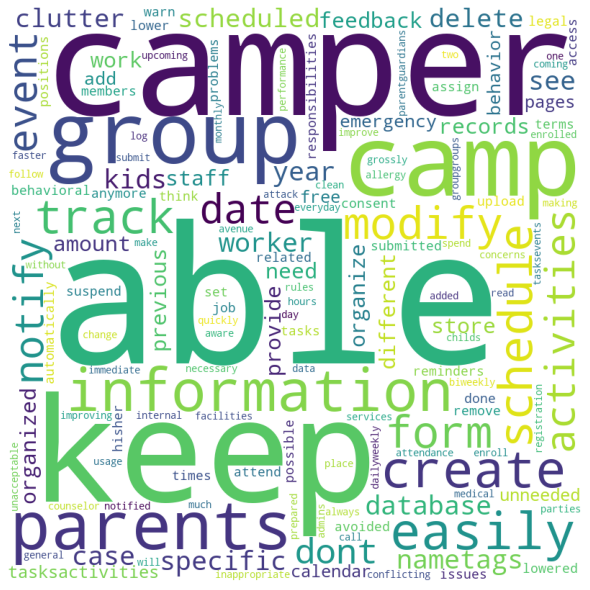



---------------------------------------archive------------------------------------------




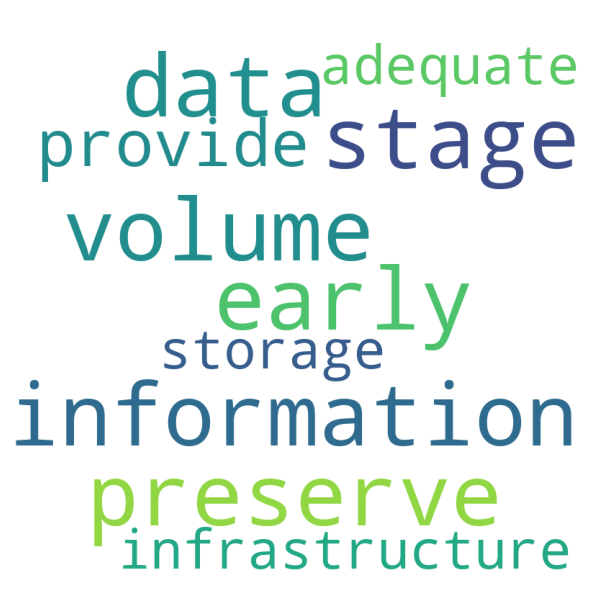



---------------------------------------user------------------------------------------




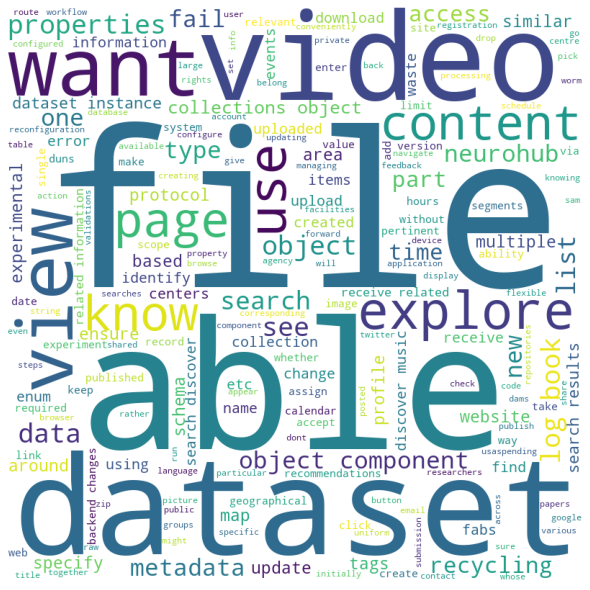



---------------------------------------sponsor------------------------------------------




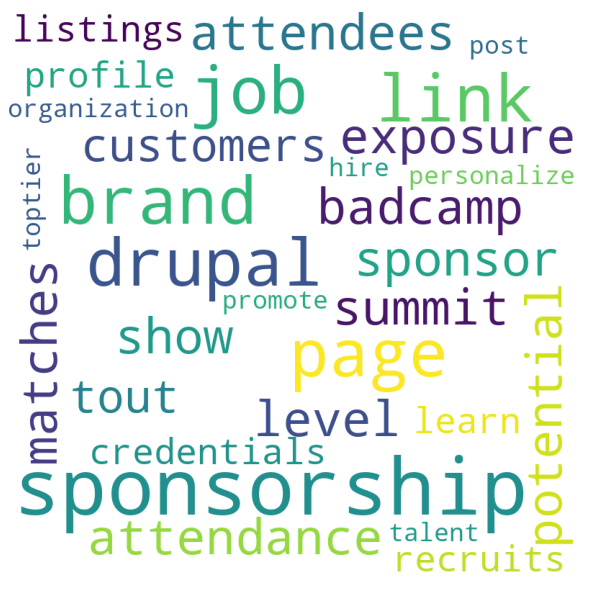



---------------------------------------participant------------------------------------------




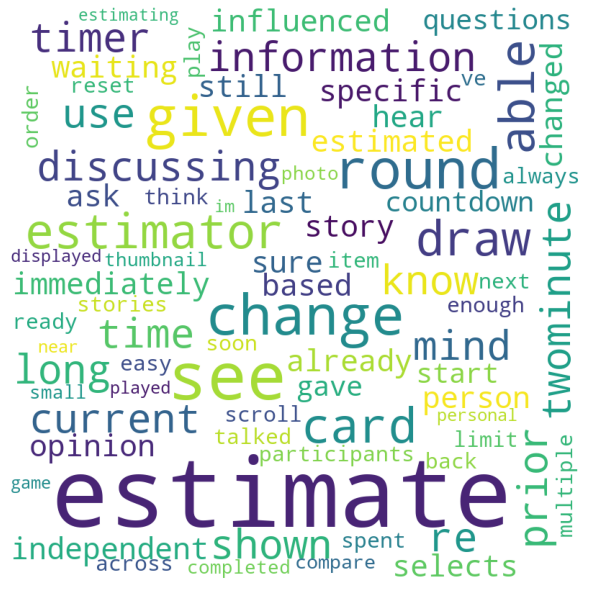

In [112]:
stakeholders = ['camp administrator',  'archive' , 'user' , 'sponsor',  'participant']

for stakeholder in stakeholders:
    df_temp = df[df['stakeholder'] == stakeholder] 

    comment_words = ''

    for story in df_temp['story']:
        tokens = story.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    print(f"\n\n---------------------------------------{stakeholder}------------------------------------------\n\n")

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


### 4. Check the syntax of user stories using any of the parsers